<a href="https://colab.research.google.com/github/kmswin1/Pytorch-Study/blob/master/Week4_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 본인의 구글 드라이브와 연동하는 과정 1
# 실행 후 밑에 나오는 링크에 들어가서 나오는 코드를 밑에 입력
# Downloaded content "Sample upload file content" 라는 메시지가 나오면 OK

# (런타임을 재시작한 경우) 아무 메시지 없이 계속 기다리는 상황이 있는데, 밑에 생기는 네모 빈 칸에 엔터 입력

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

    100% |████████████████████████████████| 993kB 21.1MB/s 


In [0]:
# 본인의 구글 드라이브와 연동하는 과정 2
# 실행 후 밑에 나오는 링크에 들어가서 나오는 코드를 밑에 입력
# Please enter the verification code: Access token retrieved correctly. 라는 메시지가 나오면 OK

# (런타임을 재시작한 경우) 아무 메시지 없이 계속 기다리는 상황이 있는데, 밑에 생기는 네모 빈 칸에 엔터 입력
# fuse: mountpoint is not empty
# fuse: if you are sure this is safe, use the 'nonempty' mount option
# 라는 메시지가 나오면 그냥 무시

# 또한 필요한 라이브러리를 설치
# 좀 시간이 걸림

!apt-get update > /dev/null
!apt-get install -y -qq software-properties-common  module-init-tools g++ > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
import sys
import timeit
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('scipy version : ', sp.__version__)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
numpy version :  1.14.6
scipy version :  1.1.0
matplotlib version : 3.0.2
pytorch version :  1.0.0
Cuda :  True


In [0]:
!ls ./drive/2019_pytorch_study

In [0]:
batchSize = 128
learningRate = 0.0002
epochNum = 30
inputDim = 28 * 28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
dataTrainDIGIT = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = True,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

dataTestDIGIT = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = False,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

trainLoaderDIGIT = torch.utils.data.DataLoader(dataset = dataTrainDIGIT, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoaderDIGIT = torch.utils.data.DataLoader(dataset = dataTestDIGIT, 
                                         batch_size = batchSize, 
                                         shuffle = False)

dataTrainFASHION = torchvision.datasets.FashionMNIST(root = './data/fashion',
                                                    train = True,
                                                    download = True,
                                                    transform = transforms.Compose([
                                                                            transforms.CenterCrop(28),
                                                                            transforms.ToTensor()]))

dataTestFASHION = torchvision.datasets.FashionMNIST(root = './data/fashion',
                                         train = False,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

trainLoaderFASHION = torch.utils.data.DataLoader(dataset = dataTrainFASHION, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoaderFASHION = torch.utils.data.DataLoader(dataset = dataTestFASHION, 
                                         batch_size = batchSize, 
                                         shuffle = False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_fashion = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot')

Processing...
Done!
Processing...
Done!


In [0]:
def show_images(image, n_row):
  
    for _ in range(n_row):  

        index=np.random.choice(100, 6) # 0 ~ 99의 정수 중  6개 랜덤 샘플링
        images =image.numpy()[index] # 랜덤 샘플링 된 index에 해당하는 이미지 변수 저장

        plt.figure(figsize=(15,90)) # 세로 사이즈 15, 가로 사이즈 15*6

        for a in range(161, 167):    

            plt.subplot(a)
            plt.imshow(images[a-161])
            plt.xticks([])
            plt.yticks([])    

        plt.show()

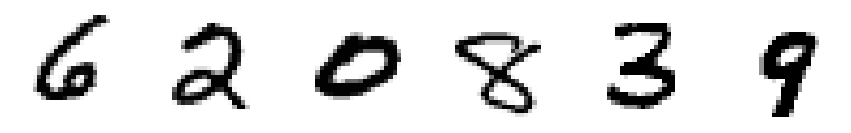

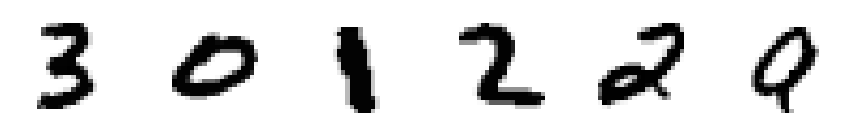

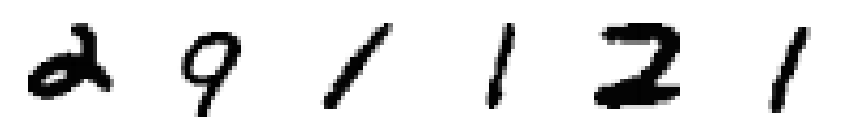

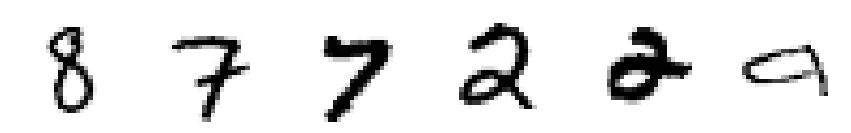

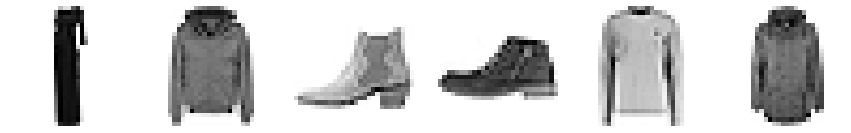

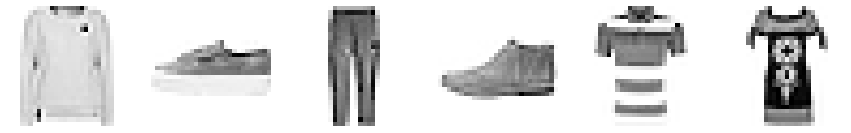

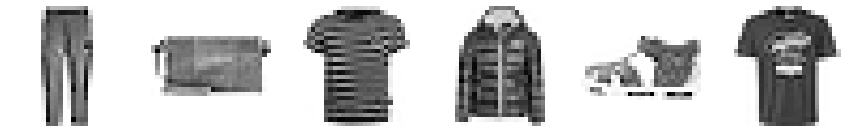

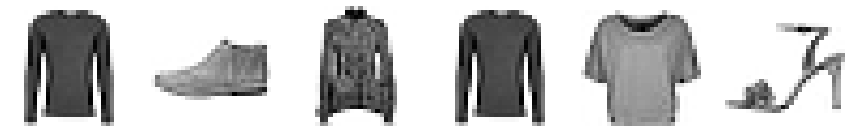

In [0]:
for i, (image,_) in enumerate(trainLoaderDIGIT): 
  
    show_images(image.squeeze(), 4)
    break

for i, (image,_) in enumerate(trainLoaderFASHION): 
  
    show_images(image.squeeze(), 4)
    break

In [0]:
class G(nn.Module):
  
    def __init__(self, ):
      
        super(G, self).__init__()

        self.conv1 = nn.Conv2d(1, 4, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(4, 16, 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(64, 256, 3, stride = 1, padding = 1)
        self.conv6 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
        self.conv7 = nn.Conv2d(512, 256, 3, stride = 1, padding = 1)
        self.conv8 = nn.Conv2d(128, 32, 3, stride = 1, padding = 1)
        self.conv9 = nn.Conv2d(32, 4, 3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(4, 1, 1, stride = 1, padding = 0)

        self.deconv1 = nn.ConvTranspose2d(256, 64, 3, stride = 2, padding = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):

        # (?, 4, 28, 28)
        out1 = F.relu(self.conv1(x.to(device)), inplace = True)
        # (?, 16, 28, 28)
        out2 = F.relu(self.conv2(out1), inplace = True)
        
        # (?, 32, 14, 14)
        out3 = F.relu(self.conv3(F.max_pool2d(out2, 2)), inplace = True)
        # (?, 64, 14, 14)
        out4 = F.relu(self.conv4(out3), inplace = True)
        
        # (?, 256, 7, 7)
        out5 = F.relu(self.conv5(F.max_pool2d(out4, 2)), inplace = True)
        # (?, 512, 7, 7)
        out6 = F.relu(self.conv6(out5))
        # (?, 256, 7, 7)
        out7 = F.relu(self.conv7(out6))
        
        # out4.shape     (?, 64, 14, 14) out8.shape    (?, 64, 14, 14)    -> torch.cat((out4, out8), 1)      (?, 128, 14, 14)
        
        # (?, 64, 14, 14)
        out8 = F.relu(self.deconv1(out7), inplace = True)
        # (?, 32, 14, 14)
        out9 = F.relu(self.conv8(torch.cat((out4, out8), 1)), inplace = True)
        
        # (?, 16, 28, 28)
        out10 = F.relu(self.deconv2(out9), inplace = True)
        # (?, 4, 28, 28)
        out11 = F.relu(self.conv9(torch.cat((out2, out10), 1)), inplace = True)
        
        # (?, 1, 28, 28)
        out = F.relu(self.conv10(out11), inplace = True)
        
        return out

class D(nn.Module):
  
    def __init__(self):
      
        super(D, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 128, 3, stride = 2, padding = 1)
        self.fc = nn.Linear(7 * 7 * 128, 1)
      
    def forward(self, x):
      
        out = F.relu(self.conv1(x.to(device)), inplace = True)
        out = F.relu(self.conv2(out), inplace = True)
        out = out.view(batchSize, -1)
        out = F.sigmoid(self.fc(out))
        
        return out

G_df = G().train()
G_fd = G().train()
D_d = D().train()
D_f = D().train()
  
G_df = G().to(device)
G_fd = G().to(device)
D_d = D().to(device)
D_f = D().to(device)

In [0]:
digit_iter = iter(trainLoaderDIGIT)
fashion_iter = iter(trainLoaderFASHION) # dataset 의 갯수가 다를때, iter 사용(둘중 하나가 끝날때 까지 반복)

print('iterNum : ', min(len(digit_iter), len(fashion_iter)))

iterNum :  469


In [0]:
G_optimizer = torch.optim.Adam(list(G_df.parameters()) + list(G_fd.parameters()), lr = learningRate)
D_optimizer = torch.optim.Adam(list(D_d.parameters()) + list(D_f.parameters()), lr = learningRate)

for epoch in range(epochNum):
 
    digit_iter = iter(trainLoaderDIGIT)
    fashion_iter = iter(trainLoaderFASHION) # dataset 의 갯수가 다를때, iter 사용(둘중 하나가 끝날때 까지 반복)

    for idx in range(min(len(digit_iter), len(fashion_iter))):

        try:
        
            mnist, _ = digit_iter.next()
            fashion, _ = fashion_iter.next()

            mnist = mnist.to(device)
            fashion = fashion.to(device)        
            fakeFashion = G_df(mnist)
            fakeDIGIT = G_fd(fashion)

            # loss from real data
            D_optimizer.zero_grad()
            D_loss = torch.mean((D_d(mnist) - 1) ** 2) + torch.mean((D_f(fashion) - 1) ** 2)
            D_loss.backward(retain_graph = True)
            D_optimizer.step()
            # loss from fake data
            D_optimizer.zero_grad()
            D_loss = torch.mean(D_d(fakeDIGIT) ** 2) + torch.mean(D_f(fakeFashion) ** 2)
            D_loss.backward(retain_graph = True)
            D_optimizer.step()

            reconstDIGIT = G_fd(fakeFashion)
            reconstFashion = G_fd(fakeDIGIT)

            G_optimizer.zero_grad()
            G_loss = torch.mean((mnist - reconstDIGIT) ** 2) +  torch.mean((fashion - reconstFashion) ** 2) # 실제 cycleGAN 의 loss 와는 다름
            G_loss.backward()
            G_optimizer.step()

            if (idx + 1) % 200 == 0:

                print("Epoch [{}/{}], step [{}/{}], D_loss : {:.4f}, G_loss {:.4f}".format(epoch + 1, epochNum, idx + 1, min(len(digit_iter), len(fashion_iter)), D_loss.item(), G_loss.item()))
                
        except:
            
            continue

    print("Epoch [{}/{}], step [{}/{}], D_loss : {:.4f}, G_loss {:.4f}".format(epoch + 1, epochNum, idx + 1, min(len(digit_iter), len(fashion_iter)), D_loss.item(), G_loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/30], step [200/469], D_loss : 0.0000, G_loss 0.3109
